# 1. Import all the libraries

In [28]:
# pip install jupyterlab mmh3 matplotlib numpy scipy seaborn pandas ipywidgets

import mmh3
import numpy as np
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 2. Sample size calculation - Two tailed test

In [29]:
mean_of_primary_metric = 0.11
variance_of_primary_metric = 0.22

def calculate_sample_size(minimum_detectable_effect):
    sample_size = 15.7 * variance_of_primary_metric / ((mean_of_primary_metric * minimum_detectable_effect * 0.01) * (mean_of_primary_metric * minimum_detectable_effect * 0.01))
    return round(sample_size)

for mde in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]:
    sample_size = calculate_sample_size(mde)
    print(f"mde={mde}, sample_size={sample_size}")
        

mde=0.5, sample_size=11418182
mde=0.6, sample_size=7929293
mde=0.7, sample_size=5825603
mde=0.8, sample_size=4460227
mde=0.9, sample_size=3524130
mde=1.0, sample_size=2854545
mde=1.1, sample_size=2359128
mde=1.2, sample_size=1982323
mde=1.3, sample_size=1689080
mde=1.4, sample_size=1456401
mde=1.5, sample_size=1268687


In [30]:
%matplotlib inline

minimum_detectable_effect = np.linspace(0.5, 1.5, 11)

@interact(mean=(0, 1, .1), variance=(0, 1, .1))
def plot(mean=0.25, variance=0.25):
    sample_size = 16 * variance / ((mean * minimum_detectable_effect * 0.01) * (mean * minimum_detectable_effect * 0.01))
    plt.figure(figsize=(10,5))
    plt.plot(minimum_detectable_effect, sample_size, 'o:', ms=10, mec = 'r')
    plt.ylim([0, 10000000])
    plt.xlim([0.4, 1.6])
    plt.title('\nSample size = 15.7 * Variance / (Mean * Minimum Detectable Effect)^2\n\n')
    plt.xlabel("Minimum Detectable Effect")
    plt.ylabel("Sample size")
    current_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    
    for x,y in zip(minimum_detectable_effect, sample_size):
        label = "{:.0f}".format(y)
        plt.annotate(label,
                     (x,y),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')
    
    plt.show()

interactive(children=(FloatSlider(value=0.25, description='mean', max=1.0), FloatSlider(value=0.25, descriptio…

# 3. Mumur3 hash

# 3.1 Fix the seed

In [31]:
seed = 42

# 3.2 Same input -> Same output

In [32]:
print(mmh3.hash128("10"), seed)

202875904975812171366468471348966582415 42


In [33]:
print(mmh3.hash128("10"), seed)

202875904975812171366468471348966582415 42


## 3.3 Avalanche Effect

In [34]:
print(mmh3.hash128("123", seed))
print(mmh3.hash128("123", seed) % 10)

221778726177922672766938095591777382555
5


In [35]:
print(mmh3.hash128("124", seed))
print(mmh3.hash128("124", seed) % 10)

300478631308732828287189327302748661621
1


In [36]:
print(mmh3.hash128("125", seed))
print(mmh3.hash128("125", seed) % 10)

44932633382209747953529363023770088344
4


In [37]:
print(mmh3.hash128("126", seed))
print(mmh3.hash128("126", seed) % 10)

304397191071659483399092354776859210033
3


## 3.4 Uncorrelated hash values

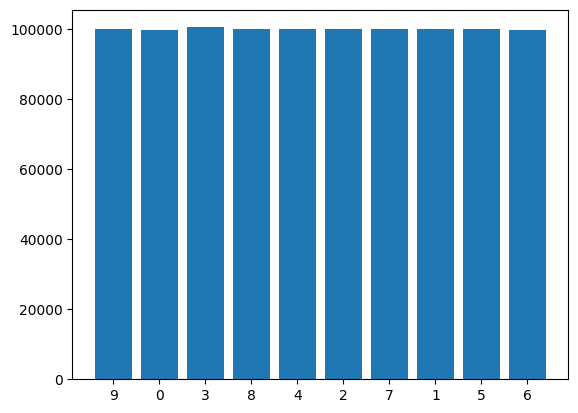

In [38]:
# calculate the mod values & update the counter
mod_counts = defaultdict(int)
for i in range(1000000):
    mod = mmh3.hash128(str(i), seed)%10
    mod_counts[mod] += 1

# plot the counts
plt.bar(range(len(mod_counts)), list(mod_counts.values()), align="center")
plt.xticks(range(len(mod_counts)), list(mod_counts.keys()))
plt.show()

# 4. User to Experiment assigment

# 4.1 User assignment to buckets & Variants

In [39]:
%matplotlib inline

@interact(user_id=(1, 500, 1))
def plot(user_id=0.25):
    plane_news_feed = mmh3.hash128(str(user_id) + str("News_feed"), seed) % 1000
    plane_messenger_feed = mmh3.hash128(str(user_id) + str("Messenger_feed"), seed) % 1000
    plane_groups_feed = mmh3.hash128(str(user_id) + str("Groups_feed"), seed) % 1000
    plane_games_feed = mmh3.hash128(str(user_id) + str("Games_feed"), seed) % 1000
    
    variant_news_feed = mmh3.hash128(str(user_id) + str("News_feed") + "Exp1", seed) % 2
    variant_messenger_feed = mmh3.hash128(str(user_id) + str("Messenger_feed") + "Exp2", seed) % 2
    variant_groups_feed = mmh3.hash128(str(user_id) + str("Groups_feed") + "Exp3", seed) % 2
    variant_games_feed = mmh3.hash128(str(user_id) + str("Games_feed") + "Exp4", seed) % 2
    
    print(f"News feed plane bucket = {plane_news_feed}, Variant = {'Control' if variant_news_feed==1 else 'Treatment'}")
    print(f"Messenger feed plane bucket = {plane_messenger_feed}, Variant = {'Control' if variant_messenger_feed==1 else 'Treatment'}")
    print(f"Groups feed plane bucket = {plane_groups_feed}, Variant = {'Control' if variant_groups_feed==1 else 'Treatment'}")
    print(f"Games feed plane bucket = {plane_games_feed}, Variant = {'Control' if variant_games_feed==1 else 'Treatment'}")
    

interactive(children=(IntSlider(value=1, description='user_id', max=500, min=1), Output()), _dom_classes=('wid…

# 5. Dataset

,Time spent in control,Time spent in variant
0,5.722458,4.434021
1,-1.078080,15.798351
2,0.720550,24.622850
3,4.843077,13.187743
4,0.126096,1.026398
...,...,...
9995,3.280751,9.478711
9996,-2.012614,11.918056
9997,4.219886,8.054048
9998,-1.550144,11.204542


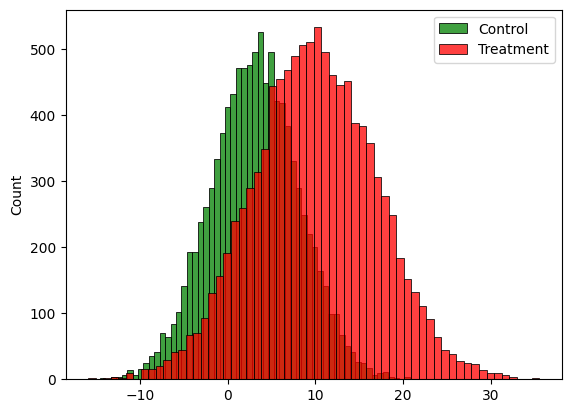

In [40]:
no_of_samples1 = 10000
no_of_samples2 = 10500

x = 3 + 5 * np.random.randn(no_of_samples1)
y = 10 + 7 * np.random.randn(no_of_samples2)

df = pd.DataFrame(data={'Time spent in control': x, 'Time spent in variant': y[:no_of_samples1]})
display(df)

sns.histplot(x, color="green")
sns.histplot(y, color="red")
plt.legend(labels=['Control', 'Treatment'])

# 5. Welch's t-test

In [41]:
def welchs_t_test_stats_library(x, y):
    t_value, p_value = stats.ttest_ind(x, y, equal_var=False)
    p_value = p_value/2
    return t_value, p_value


def welchs_t_test_from_scratch(x, y):
    n1 = len(x)
    n2 = len(y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    var = (((n1 - 1) * var_x) + ((n2 - 1) * var_y)) / (n1 + n2 - 2)
    std_error = np.sqrt(var * (1.0 / n1 + 1.0 / n2))
    t_value_absolute = abs(mean_x - mean_y) / std_error
    t_value = (mean_x - mean_y) / std_error
    p_value = 1 - stats.t.cdf(x=t_value_absolute, df=n1 + n2 - 2)
    return t_value, p_value

t_dist = stats.t(no_of_samples1 + no_of_samples2 - 2)
fill_color = (0, 0, 0, 0.1)  # Light gray in RGBA format.
line_color = (0, 0, 0, 0.5)  # Medium gray in RGBA format.
red_color = (1, 0, 0, 0.5)  # Medium gray in RGBA format.

## 6.1 Test 1: distributions are same

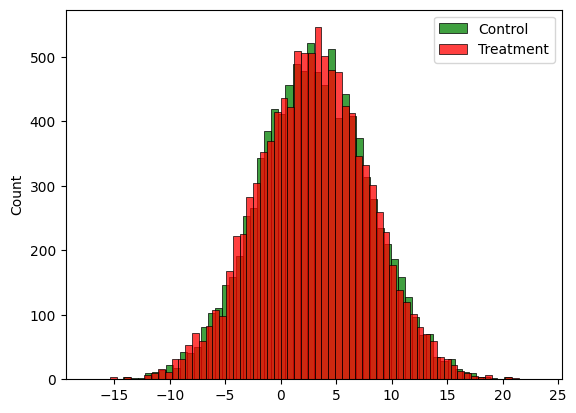

In [42]:
x = 3 + 5 * np.random.randn(no_of_samples1)
y = 3 + 5 * np.random.randn(no_of_samples2)

sns.histplot(x, color="green")
sns.histplot(y, color="red")
plt.legend(labels=['Control', 'Treatment'])

In [43]:
t_value, p_value = welchs_t_test_from_scratch(x, y)
t_value = round(t_value, 5)
p_value = round(p_value, 5)
print(f"t-value = {t_value}, p-value = {p_value}")

t-value = 0.46132, p-value = 0.32229


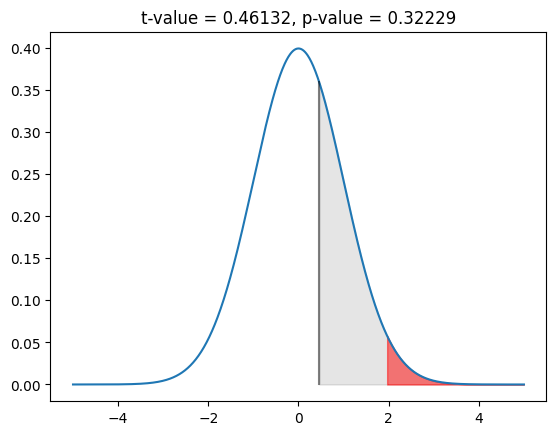

In [44]:
t_values = np.linspace(-5, 5, 1000)
pdf_values = t_dist.pdf(t_values)
cdf_values = t_dist.cdf(t_values)

plt.plot(t_values, pdf_values)
if t_value > 0:
    plt.fill_between(t_values, pdf_values, where=t_values >= t_value, color=fill_color)
    plt.fill_between(t_values, pdf_values, where=t_values >= 1.96, color=red_color)
else:
    plt.fill_between(t_values, pdf_values, where=t_values <= t_value, color=fill_color)
    plt.fill_between(t_values, pdf_values, where=t_values <= -1.96, color=red_color)
pd = t_dist.pdf(t_value)
plt.plot([t_value, t_value], [0, pd], color=line_color)
plt.title(f"t-value = {t_value}, p-value = {p_value}")

plt.show()

In [45]:
if p_value < 0.05:
    print("Reject the null hypothesis. Scale up the varaint. Make it as new control")
else:
    print("Do not reject the null hypothesis. Do not scale up the varaint")

Do not reject the null hypothesis. Do not scale up the varaint


## 6.2 Test 2: means are different

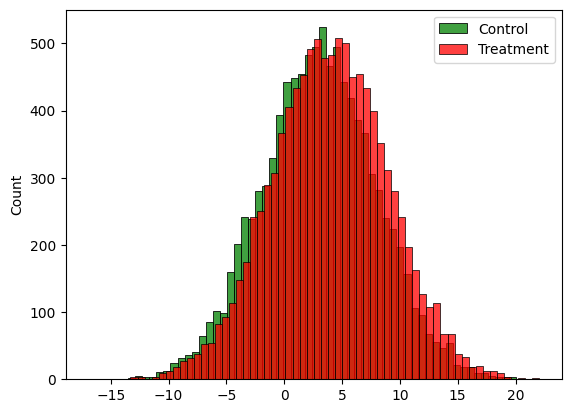

In [46]:
x = 3 + 5 * np.random.randn(no_of_samples1)
y = 4 + 5 * np.random.randn(no_of_samples2)

sns.histplot(x, color="green")
sns.histplot(y, color="red")
plt.legend(labels=['Control', 'Treatment'])

In [47]:
t_value, p_value = welchs_t_test_stats_library(x, y)
t_value = round(t_value, 5)
p_value = round(p_value, 5)
print(f"t-value = {t_value}, p-value = {p_value}")

t-value = -13.56028, p-value = 0.0


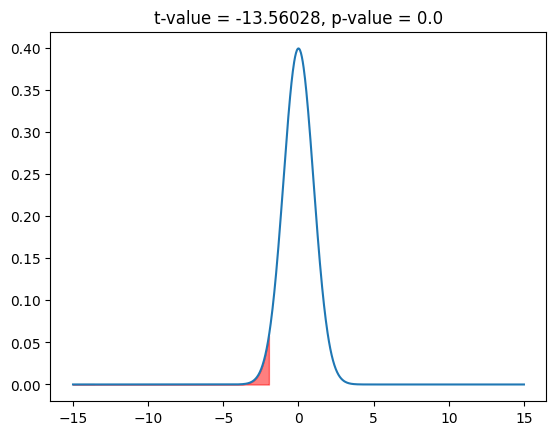

In [48]:
t_values = np.linspace(-15, 15, 1000)
pdf_values = t_dist.pdf(t_values)
cdf_values = t_dist.cdf(t_values)

plt.plot(t_values, pdf_values)
if t_value > 0:
    plt.fill_between(t_values, pdf_values, where=t_values >= t_value, color=fill_color)
    plt.fill_between(t_values, pdf_values, where=t_values >= 1.96, color=red_color)
else:
    plt.fill_between(t_values, pdf_values, where=t_values <= t_value, color=fill_color)
    plt.fill_between(t_values, pdf_values, where=t_values <= -1.96, color=red_color)
pd = t_dist.pdf(t_value)
plt.plot([t_value, t_value], [0, pd], color=line_color)
plt.title(f"t-value = {t_value}, p-value = {p_value}")

plt.show()

In [49]:
if p_value < 0.05:
    print("Reject the null hypothesis. Scale up the varaint. Make it as new control")
else:
    print("Do not reject the null hypothesis. Do not scale up the varaint")

Reject the null hypothesis. Scale up the varaint. Make it as new control


## 6.3 Test 3: standard deviations are different

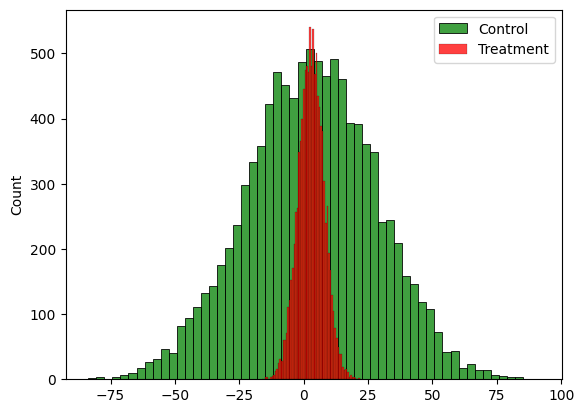

In [50]:
x = 3 + 25 * np.random.randn(no_of_samples1)
y = 3 + 5 * np.random.randn(no_of_samples2)

sns.histplot(x, color="green")
sns.histplot(y, color="red")
plt.legend(labels=['Control', 'Treatment'])

In [51]:
t_value, p_value = welchs_t_test_stats_library(x, y)
t_value = round(t_value, 5)
p_value = round(p_value, 5)
print(f"t-value = {t_value}, p-value = {p_value}")

t-value = 0.09212, p-value = 0.4633


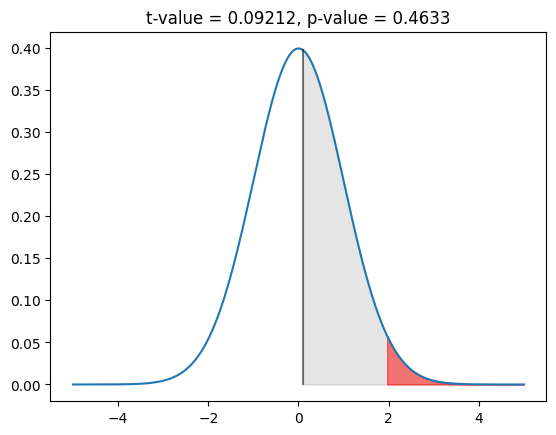

In [52]:
t_values = np.linspace(-5, 5, 1000)
pdf_values = t_dist.pdf(t_values)
cdf_values = t_dist.cdf(t_values)

plt.plot(t_values, pdf_values)
if t_value > 0:
    plt.fill_between(t_values, pdf_values, where=t_values >= t_value, color=fill_color)
    plt.fill_between(t_values, pdf_values, where=t_values >= 1.96, color=red_color)
else:
    plt.fill_between(t_values, pdf_values, where=t_values <= t_value, color=fill_color)
    plt.fill_between(t_values, pdf_values, where=t_values <= -1.96, color=red_color)
pd = t_dist.pdf(t_value)
plt.plot([t_value, t_value], [0, pd], color=line_color)
plt.title(f"t-value = {t_value}, p-value = {p_value}")

plt.show()

In [53]:
if p_value < 0.05:
    print("Reject the null hypothesis. Scale up the varaint. Make it as new control")
else:
    print("Do not reject the null hypothesis. Do not scale up the varaint")

Do not reject the null hypothesis. Do not scale up the varaint
